# AirMSPI Dynamic Radiance data loading

This notebook demonstrates how to load data from AirMSPI's files. 

A pre-processing is applied on the data for the cloud reconstruction optimization.

---


The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import shdom
import glob

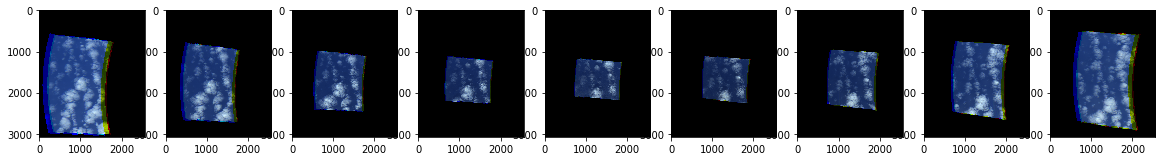

In [2]:
# Set data directory
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202514Z_NorthPacificOcean-32N123W'

format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
n_files = len(paths)
# Show AirMSPI images in data directory
shdom.AirMSPIDynamicMeasurements().imshow(data_dir)

In [3]:
# Crop cloud from images, uses OpenCV package may be problematic in some versions
roi = []
i=0

In [4]:
%matplotlib notebook 
# for i in range(i,n_files):
    # roi.append(shdom.AirMSPIMeasurements().select_region_of_interest(data_dir,i))

In [5]:
print(roi)

[]


In [6]:
# pre-calculate region of interest for demonstration for 
# AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W data
# roi = [[1552, 2072, 780, 1288], [1644, 2108, 864, 1308], [1696, 2176, 916, 1376], [1740, 2196, 936, 1400], [1840, 2108, 1040, 1432], [1884, 2160, 1064, 1500], [1944, 2316, 1116, 1540], [1972, 2480, 1136, 1600], [2052, 2544, 1204, 1640]]
roi = [[1288, 1608, 588, 835], [1356, 1680, 640, 892], [1416, 1756, 696, 940], [1480, 1820, 732, 992], [1540, 1884, 792, 1036], [1604, 1944, 828, 1085], [1660, 2012, 884, 1140], [1728, 2084, 936, 1190], [1792, 2152, 980, 1255]]

valid_wavelength = [865]
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=valid_wavelength)

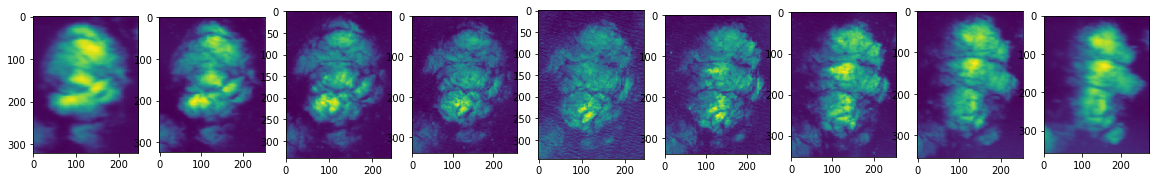

In [7]:
# View images

%matplotlib inline
f, axarr = plt.subplots(1, len(airmspi_measurements.images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, airmspi_measurements.images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    image -= image.min()
    ax.imshow(image/image.max())
    

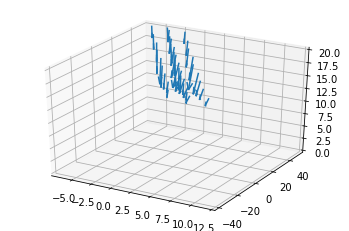

In [8]:
# Plot locations of the cameras

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init()
x_min = airmspi_measurements._projections.x.min()
x_max = airmspi_measurements._projections.x.max()
y_min = airmspi_measurements._projections.y.min()
y_max = airmspi_measurements._projections.y.max()
airmspi_measurements.plot(ax,[x_min, x_max],[y_min, y_max],[0, 20],5)

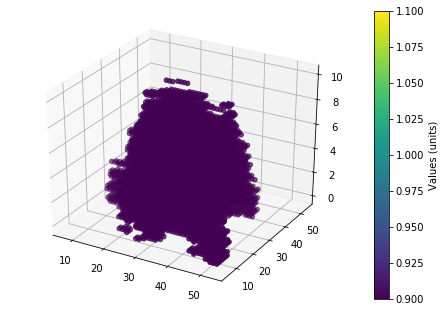

7691
[0.0, 0.0, 0]
(28.254713301261216, 31.47302041347029, 2.9062540631907425)


In [9]:
# Test cloud's pre-processing alignment by space carve object  
nx = 60
ny = 60
nz = 20

from scipy.ndimage import center_of_mass
# i=0
# for im in airmspi_measurements.images:
#     com = (center_of_mass(im))
#     im = np.zeros(im.shape)
#     im[int(com[0]),int(com[1])] = 1
#     airmspi_measurements.images[i] = im
#     i+=1
grid = shdom.Grid(bounding_box=airmspi_measurements.bb,nx=nx,ny=ny,nz=nz)
# grid = shdom.Grid(bounding_box=shdom.BoundingBox(x_min,y_min,0.0,x_max,y_max,2),nx=nx,ny=ny,nz=nz)
carver = shdom.DynamicSpaceCarver(airmspi_measurements)
mask_list, best_dynamic_grid, cloud_velocity = carver.carve(grid, agreement=0.9, thresholds=0.005,time_list=airmspi_measurements.time_list, vx_max=0,vy_max=0,verbose=False)
shdom.cloud_plot(mask_list[0].data)
print(sum(sum(sum(mask_list[0].data))))
print(cloud_velocity)
center_of_mass = center_of_mass(mask_list[0].data)
print(center_of_mass)

In [10]:
# Save AirMSPI measurments
if len(valid_wavelength) == 1:
    output_dir = 'experiments/AirMSPI/dynamic_medium/monochromatic'
else:
    output_dir = 'experiments/AirMSPI/dynamic_medium/polychromatic'
airmspi_measurements.save_airmspi_measurements(output_dir)